Starting point: https://cloud.google.com/blog/products/gcp/intro-to-text-classification-with-keras-automatically-tagging-stack-overflow-posts

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

# Data, data, data

We have 5000 StackOverflow posts that have only one tag. We want to use the post to predict what the tag is.

In [2]:
raw_data = pd.read_csv('../data/stackOverflow.csv')
raw_data.head(10)

,post,tag
0,getting absolute path of directory how do i g...,python
1,css page header/colours show up in safari but...,css
2,position absolute is not within the relative p...,css
3,extracting individual items resulting from a s...,python
4,resizable backgrounds ok i need to make a who...,css
5,why aren t these two divs displayed how i expe...,html
6,strange height size top menu in my top menu f...,css
7,what is the space between these elements wha...,html
8,javascript missing semicolon so i am using j...,javascript
9,how can we link a html button i would like t...,html


In [3]:
raw_data.tag.unique()

array(['python', 'css', 'html', 'javascript', 'jquery'], dtype=object)

The tag words probably often occur in the posts, so let's strip them out to make things a bit more challenging.

In [4]:
data = raw_data.copy()
tags = data.tag.unique()

def tag_stripper(s):
    return ' '.join(filter((lambda w: w not in tags), s.split()))

data['post'] = data.post.apply(tag_stripper)

In [5]:
data.head(10)

,post,tag
0,getting absolute path of directory how do i ge...,python
1,page header/colours show up in safari but not ...,css
2,position absolute is not within the relative p...,css
3,extracting individual items resulting from a s...,python
4,resizable backgrounds ok i need to make a whol...,css
5,why aren t these two divs displayed how i expe...,html
6,strange height size top menu in my top menu fo...,css
7,what is the space between these elements what ...,html
8,missing semicolon so i am using jsfiddle.net t...,javascript
9,how can we link a button i would like to creat...,html


### How long are the posts?

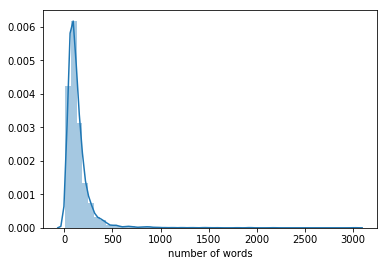

In [6]:
post_lengths = data.post.apply(lambda s: len(s.split()))
sns.distplot(post_lengths, axlabel="number of words")

In [7]:
avg_length = np.mean(post_lengths)
median_length = np.median(post_lengths)

print(f"The average length of the posts in {avg_length} words, with half the posts having less than {median_length} words.")
post_lengths.describe()

The average length of the posts in 138.532 words, with half the posts having less than 105.0 words.


count    5000.00000
mean      138.53200
std       139.37451
min         8.00000
25%        68.00000
50%       105.00000
75%       162.00000
max      3019.00000
Name: post, dtype: float64

### Split into training data and testing data

It is **crucial** that we test our classifier using data that was **not** used to build. We split the data into two chunks, the data used to train (ie. build) the classifier, and the data we will later use to test it.

In [8]:
train_data = data[:4000]
test_data = data[4000:]
print(f"Training on {len(train_data)} rows")
print(f"Testing on {len(test_data)} rows")

Training on 4000 rows
Testing on 1000 rows


# Build a classifier!

### Convert posts to word counts

We will use a **bag of words** approach. Here we ignore what the posts mean, and we even ignore the order of the words in the post. (!) All that matters is the number of times each word appears.

We convert the words into numbers, and the posts into vectors of word counts.

In [9]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(train_data.post)

In [10]:
print(f"Number of words in the training data: {len(vectorizer.get_feature_names())}")
print(f"first 10: {', '.join(vectorizer.get_feature_names()[:10])}")
print(f"middle 10: {', '.join(vectorizer.get_feature_names()[13000:13010])}")

Number of words in the training data: 26878
first 10: 00, 000, 0000, 00000, 000000, 0000000, 000000000, 00001, 0000121593475342, 000016
middle 10: ideal, ideally, idealy, ideas, ident, identical, identically, identifications, identified, identifier


Lets look at the first post.

In [11]:
print(f" tag: {train_data.tag.tolist()[0]}")
print(f"post: {train_data.post.tolist()[0]}")

 tag: python
post: getting absolute path of directory how do i get the absolute path of a directory (it has to be any directory not the current one!) in i tried with <code>os.path.listdir()</code> but it yields only the relative one. thanks!


In [12]:
word_counts[0]

<1x26878 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

The first post has 28 different words. We encode it as a sparse vector rather than one that's almost all zeros.

In [13]:
print(word_counts[0])

  (0, 23915)	1
  (0, 20271)	1
  (0, 17659)	1
  (0, 26612)	1
  (0, 5930)	1
  (0, 15095)	1
  (0, 17903)	1
  (0, 6946)	2
  (0, 26169)	1
  (0, 24558)	1
  (0, 13266)	1
  (0, 17627)	2
  (0, 7983)	1
  (0, 17186)	1
  (0, 4309)	1
  (0, 5159)	1
  (0, 24237)	1
  (0, 12420)	1
  (0, 13925)	2
  (0, 23923)	3
  (0, 11721)	1
  (0, 9133)	1
  (0, 12803)	1
  (0, 8914)	3
  (0, 17515)	2
  (0, 18367)	3
  (0, 3495)	2
  (0, 11901)	1


In [14]:
vectorizer.get_feature_names()[8914]

'directory'

### Naively classifying

Our classifier will have two steps. First we convert the data into word counts as above. Then we use these word counts in a Naive Bayes classifier. 

This is pretty much the simplest classifier we can use. It has few parameters but makes lots of assumptions about the data that are totally wrong. 

For example, it assumes that the words appear independently, ie one word appearing in a post doesn't change the likelihood of one of the other words appearing.

Since our posts are sentences, this is really wrong.

In [78]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [80]:
predictions = classifier.predict(test_data.post)
accuracy = metrics.accuracy_score(test_data.tag, predictions)
print(f"Average chance that a prediction is correct: {accuracy * 100:.0f}%")
print("Not terrible!")

Average chance that a prediction is correct: 73%
Not terrible!


A **confusion matrix** shows us how many things got classified as other things.

In [17]:
tags = test_data.tag.unique()
row_index = pd.MultiIndex.from_tuples([('actual', x) for x in tags])
col_index = pd.MultiIndex.from_tuples([('predicted', x) for x in tags])
confusion_matrix = metrics.confusion_matrix(test_data.tag, predictions, labels=tags)

df = pd.DataFrame(confusion_matrix, index=row_index, columns=col_index)
df['Count'] = df[df.columns].sum(axis=1)
s = df.sum()
s.name = ('actual', "Count")
df = df.append(s)

confusion_matrix_4000 = df
confusion_matrix_4000

predicted                             Count
                     python jquery javascript  css html      
actual python           184      0          4    2    0   190
       jquery             5    133         37    4   16   195
       javascript        23     28        138    6   13   208
       css                3      8          6  162   23   202
       html              19     24         15   35  112   205
       Count            234    193        200  209  164  1000

Three important measures of how good a classifier is are **precision**, **recall** and **f1-score**. Values of 1 is good, zero is bad.

\begin{align}
\text{precision of tag} & = \frac {\text {number with that tag guessed correctly}} 
                                        {\text{total number of times we guessed that tag}} \\
                             & = \text {how much of our guesses of that tag were correct} \\
                             \\
\text{recall of tag} &= \frac {\text {number with that tag guessed correctly}} 
                                        {\text{number with that tag}} \\
                          &= \text {how much of that tag we guessed correctly} \\
                          \\
\text{f1-score} &= \text{combination of precision and recall} \\
\end{align}




In [18]:
print(metrics.classification_report(y_true=test_data.tag, y_pred=predictions))

              precision    recall  f1-score   support

         css       0.78      0.80      0.79       202
        html       0.68      0.55      0.61       205
  javascript       0.69      0.66      0.68       208
      jquery       0.69      0.68      0.69       195
      python       0.79      0.97      0.87       190

   micro avg       0.73      0.73      0.73      1000
   macro avg       0.72      0.73      0.73      1000
weighted avg       0.72      0.73      0.72      1000



### What if we don't have much data?

In [82]:
train_data = data[:100]
print(f"Training on {len(train_data)} rows")
print(f"Testing on {len(test_data)} rows")

Training on 100 rows
Testing on 1000 rows


In [83]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
accuracy = metrics.accuracy_score(test_data.tag, predictions)
print(f"Previous chance that a prediction was correct: {accuracy * 100:.0f}%")
predictions = classifier.predict(test_data.post)
accuracy = metrics.accuracy_score(test_data.tag, predictions)
print(f"      New chance that a prediction is correct: {accuracy * 100:.0f}%")

Previous chance that a prediction was correct: 73%
      New chance that a prediction is correct: 56%


In [84]:
print(metrics.classification_report(y_true=test_data.tag, y_pred=predictions))

              precision    recall  f1-score   support

         css       0.58      0.76      0.66       202
        html       0.51      0.43      0.47       205
  javascript       0.44      0.78      0.57       208
      jquery       0.73      0.24      0.36       195
      python       0.83      0.58      0.68       190

   micro avg       0.56      0.56      0.56      1000
   macro avg       0.62      0.56      0.55      1000
weighted avg       0.62      0.56      0.55      1000



In [85]:
print(f"So we only have a {accuracy * 100:.0f}% change of being right.")
print("But we only trained with 100 posts, ie. about 20 per tag.")
print("If we guessed randomly we'd have a 1 / 5 = 20% chance of being right.")
print(f"With very little data we boosted that to {accuracy * 100:.0f}%.")

So we only have a 56% change of being right.
But we only trained with 100 posts, ie. about 20 per tag.
If we guessed randomly we'd have a 1 / 5 = 20% chance of being right.
With very little data we boosted that to 56%.


# Tweak things

### Stop words

**Stop words** are words that have no information value, such as `the`, `a`, or `or`. Removing them from our data might improve things.

### n-grams

We used word counts. What if instead we counted pairs of words? Or triples?

### Normalize word counts

If a document is really long it will in general have higher word counts, so it might seem to be more relavant than a shorter doccument which uses key words relatively more often. 

To counter this we usually normalize the counts by the length of the document in some fashion.

Also, if a word occurs in most of the documents, it probably doesn't have much information value. So we want to reduce its score.

A common way to do both of these is to calculate the Term Frequency Inverse Document Frequency (TFIDF).

## Let's try these!

In [86]:
train_data = data[:4000]
test_data = data[4000:]

### Original Naive Bayes

In [28]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"Original chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

Original chance that a prediction is correct: 73%


### TFIDF

In [29]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"Original chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

Original chance that a prediction is correct: 74%


### Try stopwords

In [87]:
classifier = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"Stopwords chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

Stopwords chance that a prediction is correct: 73%


### Try n-grams

In [31]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"2-grams chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

2-grams chance that a prediction is correct: 76%


In [91]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3))),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"      New chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

      New chance that a prediction is correct: 76%


### Both?

In [33]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2), stop_words=stopWords)),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"      New chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

      New chance that a prediction is correct: 75%


### SVG?

In [92]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(alpha=0.1, random_state=42, max_iter=20, tol=0.3)),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"SVG 2-gram chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

SVG 2-gram chance that a prediction is correct: 80%


### Try on small data set

In [35]:
train_data = data[:100]
test_data = data[4000:]

In [36]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"Original chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

Original chance that a prediction is correct: 56%


In [37]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"2-gram chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

2-gram chance that a prediction is correct: 53%


### Try an SVG?

In [38]:
classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=20, tol=0.01)),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"SVG 2-gram chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

SVG 2-gram chance that a prediction is correct: 54%


## Try a bunch of other classifiers

In [54]:
train_data = data[:4000]
test_data = data[4000:]

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

In [56]:
result_cols = ["Classifier", "Accuracy"]

In [60]:
classifiers = [
    MultinomialNB(),
    KNeighborsClassifier(5),
    SVC(kernel="rbf", C=0.025, probability=True, gamma='auto'),
    NuSVC(probability=True, gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier()
]

In [61]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer()),
#                          ('tfidf', TfidfTransformer()),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 73%
KNeighborsClassifier accuracy = 50%
SVC accuracy = 20%
NuSVC accuracy = 75%
DecisionTreeClassifier accuracy = 68%
RandomForestClassifier accuracy = 77%
AdaBoostClassifier accuracy = 68%


,Classifier,Accuracy
0,MultinomialNB,72.9
0,KNeighborsClassifier,50.2
0,SVC,19.6
0,NuSVC,75.1
0,DecisionTreeClassifier,68.4
0,RandomForestClassifier,77.3
0,AdaBoostClassifier,67.9


In [62]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
#                          ('tfidf', TfidfTransformer()),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 76%
KNeighborsClassifier accuracy = 48%
SVC accuracy = 19%
NuSVC accuracy = 74%
DecisionTreeClassifier accuracy = 69%
RandomForestClassifier accuracy = 77%
AdaBoostClassifier accuracy = 68%


,Classifier,Accuracy
0,MultinomialNB,76.1
0,KNeighborsClassifier,48.4
0,SVC,19.0
0,NuSVC,74.5
0,DecisionTreeClassifier,69.3
0,RandomForestClassifier,77.2
0,AdaBoostClassifier,68.0


In [65]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer()),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 76%
KNeighborsClassifier accuracy = 61%
SVC accuracy = 19%
NuSVC accuracy = 47%
DecisionTreeClassifier accuracy = 65%
RandomForestClassifier accuracy = 77%
AdaBoostClassifier accuracy = 68%


,Classifier,Accuracy
0,MultinomialNB,75.9
0,KNeighborsClassifier,60.8
0,SVC,19.0
0,NuSVC,47.4
0,DecisionTreeClassifier,65.3
0,RandomForestClassifier,76.6
0,AdaBoostClassifier,68.4


In [67]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words=stopWords)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 75%
KNeighborsClassifier accuracy = 59%
SVC accuracy = 19%
NuSVC accuracy = 49%
DecisionTreeClassifier accuracy = 67%
RandomForestClassifier accuracy = 76%
AdaBoostClassifier accuracy = 67%


,Classifier,Accuracy
0,MultinomialNB,75.1
0,KNeighborsClassifier,59.0
0,SVC,19.0
0,NuSVC,48.8
0,DecisionTreeClassifier,66.8
0,RandomForestClassifier,76.3
0,AdaBoostClassifier,67.2


In [72]:
classifiers = [
    MultinomialNB(),
    SGDClassifier(loss='hinge', penalty='l2', alpha=1, random_state=42, max_iter=20, tol=0.01),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier()
]

In [73]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 74%
SGDClassifier accuracy = 37%
KNeighborsClassifier accuracy = 59%
DecisionTreeClassifier accuracy = 68%
RandomForestClassifier accuracy = 74%
AdaBoostClassifier accuracy = 67%


,Classifier,Accuracy
0,MultinomialNB,74.5
0,SGDClassifier,37.4
0,KNeighborsClassifier,59.3
0,DecisionTreeClassifier,67.9
0,RandomForestClassifier,74.4
0,AdaBoostClassifier,66.9


## Best

In [93]:
classifiers = [
    MultinomialNB(),
    NuSVC(probability=True, gamma='auto'),
    SGDClassifier(alpha=0.1, random_state=42, max_iter=20, tol=0.3),
    RandomForestClassifier(n_estimators=100),
]

In [94]:
result_frame = pd.DataFrame(columns=result_cols)

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                         ('clf', clf),])
    text_clf.fit(train_data.post, train_data.tag)
    
    predicted = text_clf.predict(test_data.post)
    acc = metrics.accuracy_score(test_data.tag, predicted)
    print (f'{name} accuracy = {acc*100:.0f}%')
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)

result_frame

MultinomialNB accuracy = 76%
NuSVC accuracy = 74%
SGDClassifier accuracy = 80%
RandomForestClassifier accuracy = 76%


,Classifier,Accuracy
0,MultinomialNB,76.1
0,NuSVC,74.5
0,SGDClassifier,80.4
0,RandomForestClassifier,75.9


# Extra

In [ ]:
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

stopWords = set(stopwords.words('english'))

print(stopWords)